# Sales Analysis

In [1]:
import math
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
path = "E:\Resume\PyProj"
files = [file for file in os.listdir(path) if not file.startswith('.')] # Ignore hidden files

all_months_data = pd.DataFrame()

for file in files:
    current_data = pd.read_csv(path+"/"+file)
    all_months_data = pd.concat([all_months_data, current_data])
    
all_months_data.to_csv("all_data_copy.csv", index=False)

In [3]:
all_data = pd.read_csv("E:\Resume\PyProj/all_data_copy.csv")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


## Data Clean up

### Drop rows of NAN

In [4]:
nan_df = all_data[all_data.isna().any(axis=1)]
display(nan_df.head())

all_data = all_data.dropna(how='all')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1,NaN,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,NaN
735,NaN,NaN,NaN,NaN,NaN,NaN
1433,NaN,NaN,NaN,NaN,NaN,NaN
1553,NaN,NaN,NaN,NaN,NaN,NaN


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


### Get rid of text in order date column

In [5]:
all_data = all_data[all_data['Order Date'].str[0:2]!='Or']

### Change Datatype

In [6]:
all_data['Quantity Ordered'] = pd.to_numeric(all_data['Quantity Ordered'])
all_data['Price Each'] = pd.to_numeric(all_data['Price Each'])

### Add month column

In [7]:
all_data['Month'] = all_data['Order Date'].str[0:2]
all_data['Month'] = all_data['Month'].astype('int32')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4


### Add city column

In [8]:
def get_city(address):
    return address.split(",")[1].strip(" ")

def get_state(address):
    return address.split(",")[2].split(" ")[1]

all_data['City'] = all_data['Purchase Address'].apply(lambda x: f"{get_city(x)}  ({get_state(x)})")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,Dallas (TX)
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,Boston (MA)
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA)
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA)
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,Los Angeles (CA)


### Data Analysis

#### What was the best month for sales? How much was earned that month?

In [9]:
all_data['Sales'] = all_data['Quantity Ordered'].astype('int') * all_data['Price Each'].astype('float')
all_data.groupby(['Month']).sum()

,Quantity Ordered,Price Each,Sales
Month,,,
1,10903,1.811768e+06,1.822257e+06
2,13449,2.188885e+06,2.202022e+06
3,17005,2.791208e+06,2.807100e+06
4,20558,3.367671e+06,3.390670e+06
5,18667,3.135125e+06,3.152607e+06
6,15253,2.562026e+06,2.577802e+06
7,16072,2.632540e+06,2.647776e+06
8,13448,2.230345e+06,2.244468e+06
9,13109,2.084992e+06,2.097560e+06


range(1, 13)


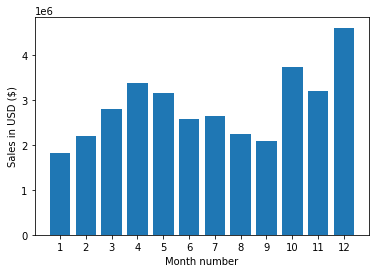

In [10]:
import matplotlib.pyplot as plt

months = range(1,13)
print(months)

plt.bar(months,all_data.groupby(['Month']).sum()['Sales'])
plt.xticks(months)
plt.ylabel('Sales in USD ($)')
plt.xlabel('Month number')
plt.show()

#### What city sold the most product?

In [11]:
all_data.groupby(['City']).sum()

,Quantity Ordered,Price Each,Month,Sales
City,,,,
Atlanta (GA),16602,2.779908e+06,104794,2.795499e+06
Austin (TX),11153,1.809874e+06,69829,1.819582e+06
Boston (MA),22528,3.637410e+06,141112,3.661642e+06
Dallas (TX),16730,2.752628e+06,104620,2.767975e+06
Los Angeles (CA),33289,5.421435e+06,208325,5.452571e+06
New York City (NY),27932,4.635371e+06,175741,4.664317e+06
Portland (ME),2750,4.471893e+05,17144,4.497583e+05
Portland (OR),11303,1.860558e+06,70621,1.870732e+06
San Francisco (CA),50239,8.211462e+06,315520,8.262204e+06


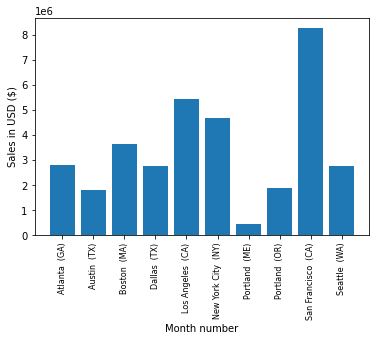

In [12]:
keys = [city for city, df in all_data.groupby(['City'])]

plt.bar(keys,all_data.groupby(['City']).sum()['Sales'])
plt.ylabel('Sales in USD ($)')
plt.xlabel('Month number')
plt.xticks(keys, rotation='vertical', size=8)
plt.show()

#### What time should we display advertisements to maximize likelihood of customer's buying product?

In [13]:
all_data['Hour'] = pd.to_datetime(all_data['Order Date']).dt.hour
all_data['Minute'] = pd.to_datetime(all_data['Order Date']).dt.minute
all_data['Count'] = 1
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Sales,Hour,Minute,Count
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,Dallas (TX),23.90,8,46,1
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,Boston (MA),99.99,22,30,1
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),600.00,14,38,1
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,14,38,1
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,9,27,1


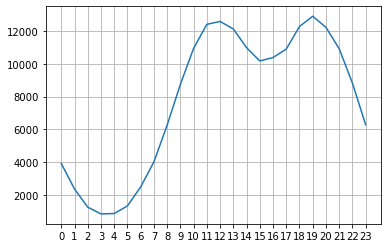

In [14]:
keys = [pair for pair, df in all_data.groupby(['Hour'])]

plt.plot(keys, all_data.groupby(['Hour']).count()['Count'])
plt.xticks(keys)
plt.grid()
plt.show()

#### What products are most often sold together?

In [15]:
df = all_data[all_data['Order ID'].duplicated(keep=False)]
df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
df2 = df[['Order ID', 'Grouped']].drop_duplicates()

<ipython-input-15-1accdb5968b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))


In [16]:
from itertools import combinations
from collections import Counter

count = Counter()

for row in df2['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

for key,value in count.most_common(10):
    print(key, value)

('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


#### What product sold the most? Why do you think it sold the most?

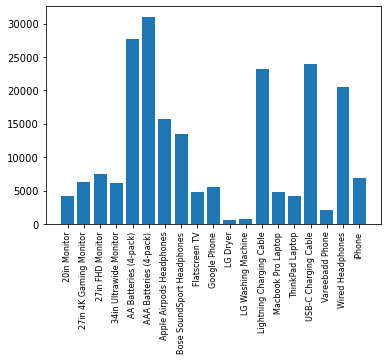

In [17]:
product_group = all_data.groupby('Product')
quantity_ordered = product_group.sum()['Quantity Ordered']

keys = [pair for pair, df in product_group]
plt.bar(keys, quantity_ordered)
plt.xticks(keys, rotation='vertical', size=8)
plt.show()

<ipython-input-18-47066c2f195f>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(keys, rotation='vertical', size=8)
<ipython-input-18-47066c2f195f>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


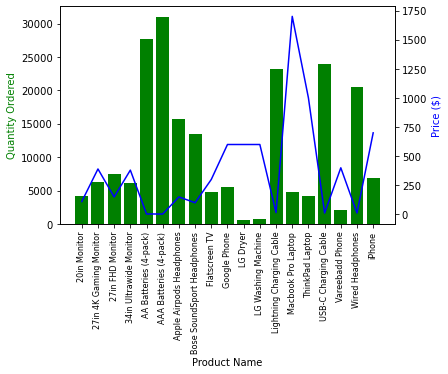

In [18]:
prices = all_data.groupby('Product').mean()['Price Each']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(keys, quantity_ordered, color='g')
ax2.plot(keys, prices, color='b')

ax1.set_xlabel('Product Name')
ax1.set_ylabel('Quantity Ordered', color='g')
ax2.set_ylabel('Price ($)', color='b')
ax1.set_xticklabels(keys, rotation='vertical', size=8)

fig.show()

In [19]:
all_data

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Sales,Hour,Minute,Count
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,Dallas (TX),23.90,8,46,1
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,Boston (MA),99.99,22,30,1
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),600.00,14,38,1
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,14,38,1
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,9,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...
186845,259353,AAA Batteries (4-pack),3,2.99,09/17/19 20:56,"840 Highland St, Los Angeles, CA 90001",9,Los Angeles (CA),8.97,20,56,1
186846,259354,iPhone,1,700.00,09/01/19 16:00,"216 Dogwood St, San Francisco, CA 94016",9,San Francisco (CA),700.00,16,0,1
186847,259355,iPhone,1,700.00,09/23/19 07:39,"220 12th St, San Francisco, CA 94016",9,San Francisco (CA),700.00,7,39,1
186848,259356,34in Ultrawide Monitor,1,379.99,09/19/19 17:30,"511 Forest St, San Francisco, CA 94016",9,San Francisco (CA),379.99,17,30,1


## LSTM Model

In [20]:
df = all_data
from datetime import datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Order Date'] = df['Order Date'].dt.date
df['Purchase Address'] = df['Purchase Address'].astype(str)
df['City'] = df['Purchase Address'].str.split(',').str[1].astype(str)
df['Quantity Ordered'] = df['Quantity Ordered'].astype(int)
df['Price Each'] = df['Price Each'].astype(float)
df = df.groupby(['Order Date','Product'])['Quantity Ordered'].sum().reset_index()
df.head(10)

,Order Date,Product,Quantity Ordered
0,2019-01-01,20in Monitor,4
1,2019-01-01,27in 4K Gaming Monitor,7
2,2019-01-01,27in FHD Monitor,8
3,2019-01-01,34in Ultrawide Monitor,18
4,2019-01-01,AA Batteries (4-pack),33
5,2019-01-01,AAA Batteries (4-pack),61
6,2019-01-01,Apple Airpods Headphones,21
7,2019-01-01,Bose SoundSport Headphones,15
8,2019-01-01,Flatscreen TV,9
9,2019-01-01,Google Phone,12


In [21]:
#groupby date and sum the sales
df_sales = df.groupby(['Order Date'])['Quantity Ordered'].sum().reset_index()
df_sales['year'] = pd.DatetimeIndex(df_sales['Order Date']).year
df_1 = df_sales.loc[df_sales['year']!=2020]
df_1 = df_1.drop(columns=['year'])
df_sales = df_1
df_sales

,Order Date,Quantity Ordered
0,2019-01-01,343
1,2019-01-02,368
2,2019-01-03,330
3,2019-01-04,330
4,2019-01-05,355
...,...,...
360,2019-12-27,869
361,2019-12-28,931
362,2019-12-29,954
363,2019-12-30,928


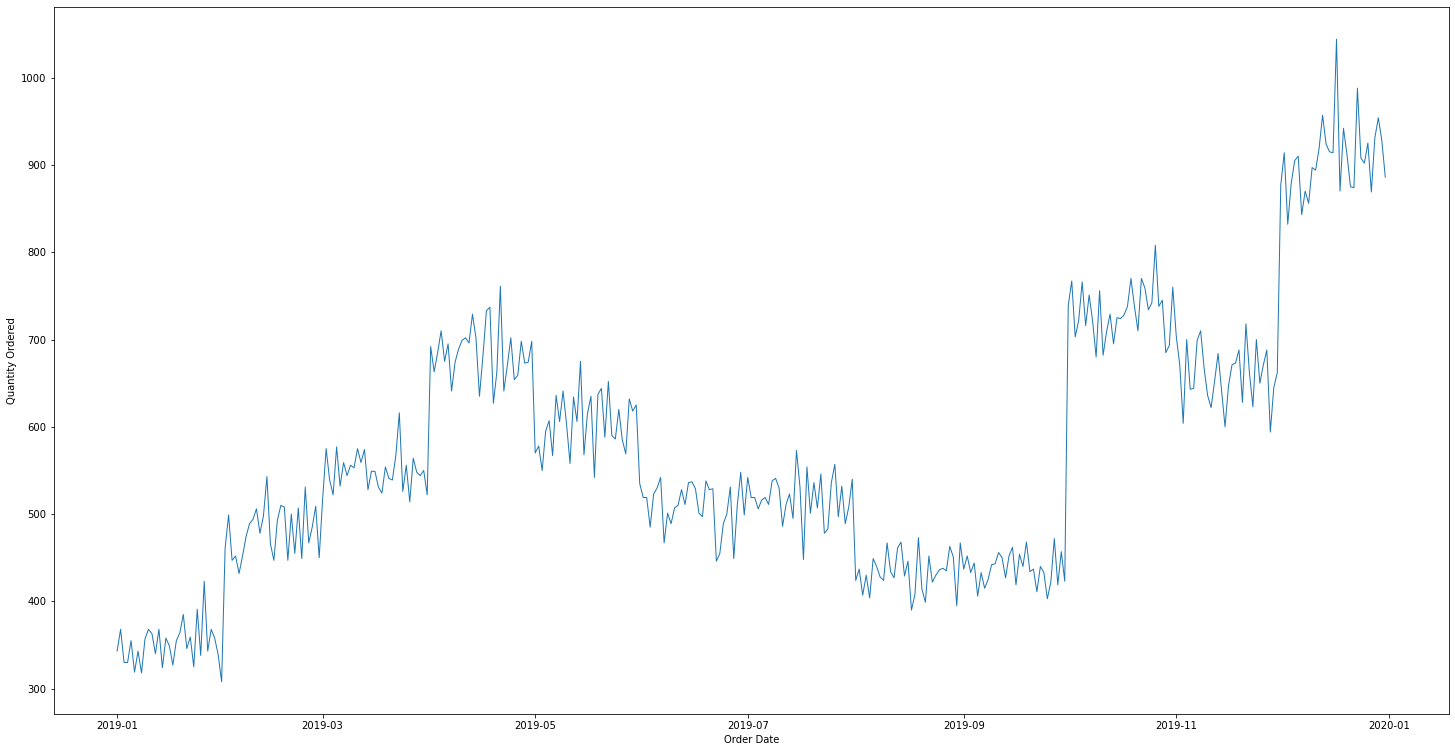

In [22]:
plt.figure(figsize=(25,13))
plt.plot(df_sales['Order Date'], df_sales['Quantity Ordered'], linewidth=1)
plt.xlabel('Order Date')
plt.ylabel('Quantity Ordered')
plt.show()

In [23]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['Quantity Ordered'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Quantity Ordered'] - df_diff['prev_sales'])
df_diff

,Order Date,Quantity Ordered,prev_sales,diff
1,2019-01-02,368,343.0,25.0
2,2019-01-03,330,368.0,-38.0
3,2019-01-04,330,330.0,0.0
4,2019-01-05,355,330.0,25.0
5,2019-01-06,319,355.0,-36.0
...,...,...,...,...
360,2019-12-27,869,925.0,-56.0
361,2019-12-28,931,869.0,62.0
362,2019-12-29,954,931.0,23.0
363,2019-12-30,928,954.0,-26.0


In [24]:
# df_diff=df_diff.reset_index()['diff']
df_diff.head(10)

,Order Date,Quantity Ordered,prev_sales,diff
1,2019-01-02,368,343.0,25.0
2,2019-01-03,330,368.0,-38.0
3,2019-01-04,330,330.0,0.0
4,2019-01-05,355,330.0,25.0
5,2019-01-06,319,355.0,-36.0
6,2019-01-07,343,319.0,24.0
7,2019-01-08,318,343.0,-25.0
8,2019-01-09,357,318.0,39.0
9,2019-01-10,368,357.0,11.0
10,2019-01-11,363,368.0,-5.0


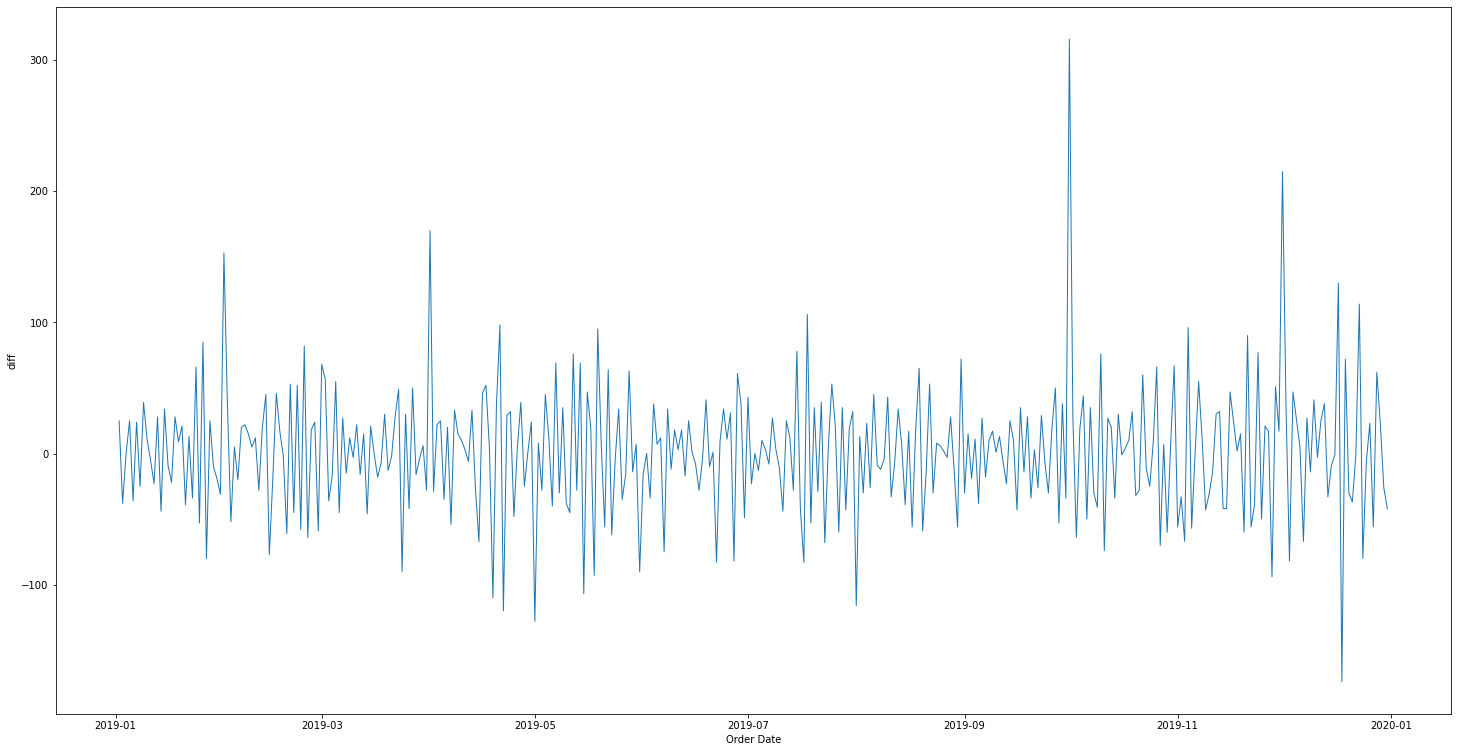

In [25]:
plt.figure(figsize=(25,13))
plt.plot(df_diff['Order Date'],df_diff['diff'] , linewidth=1)
plt.xlabel('Order Date')
plt.ylabel('diff')
plt.show()

In [26]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,16):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

df_supervised

,Order Date,Quantity Ordered,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
0,2019-01-17,327,-22.0,-9.0,34.0,-44.0,28.0,-23.0,-5.0,11.0,39.0,-25.0,24.0,-36.0,25.0,0.0,-38.0,25.0
1,2019-01-18,355,28.0,-22.0,-9.0,34.0,-44.0,28.0,-23.0,-5.0,11.0,39.0,-25.0,24.0,-36.0,25.0,0.0,-38.0
2,2019-01-19,364,9.0,28.0,-22.0,-9.0,34.0,-44.0,28.0,-23.0,-5.0,11.0,39.0,-25.0,24.0,-36.0,25.0,0.0
3,2019-01-20,385,21.0,9.0,28.0,-22.0,-9.0,34.0,-44.0,28.0,-23.0,-5.0,11.0,39.0,-25.0,24.0,-36.0,25.0
4,2019-01-21,346,-39.0,21.0,9.0,28.0,-22.0,-9.0,34.0,-44.0,28.0,-23.0,-5.0,11.0,39.0,-25.0,24.0,-36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,2019-12-27,869,-56.0,23.0,-6.0,-80.0,114.0,-1.0,-37.0,-30.0,72.0,-174.0,130.0,-1.0,-9.0,-33.0,38.0,25.0
345,2019-12-28,931,62.0,-56.0,23.0,-6.0,-80.0,114.0,-1.0,-37.0,-30.0,72.0,-174.0,130.0,-1.0,-9.0,-33.0,38.0
346,2019-12-29,954,23.0,62.0,-56.0,23.0,-6.0,-80.0,114.0,-1.0,-37.0,-30.0,72.0,-174.0,130.0,-1.0,-9.0,-33.0
347,2019-12-30,928,-26.0,23.0,62.0,-56.0,23.0,-6.0,-80.0,114.0,-1.0,-37.0,-30.0,72.0,-174.0,130.0,-1.0,-9.0


## Divide the training set and the test set

### 80% data for training
### 20% data for testing

In [27]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['Order Date','Quantity Ordered'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-292].values, df_model[-292:].values

In [28]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

## Building the LSTM model

In [29]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### Performing model training

In [30]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
57/57 [==============================] - 3s 2ms/step - loss: 0.1913
Epoch 2/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1537
Epoch 3/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1487
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1464
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1442
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1421
Epoch 7/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1399
Epoch 8/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1376
Epoch 9/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1353
Epoch 10/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1329
Epoch 11/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1304
Epoch 12/100
57/57 [==============================] - 0s 2ms/step - loss: 0.1278
Epoch 13/100
57/57 [=================

In [31]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

292/292 [==============================] - 1s 1ms/step


In [32]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [33]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
#     print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

In [34]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [35]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [36]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-293:]['Order Date'])
act_sales = list(df_sales[-293:]['Quantity Ordered'])
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['Order Date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [37]:
df_result

,pred_value,Order Date
0,544,2019-03-15
1,552,2019-03-16
2,517,2019-03-17
3,540,2019-03-18
4,561,2019-03-19
...,...,...
287,917,2019-12-27
288,911,2019-12-28
289,968,2019-12-29
290,945,2019-12-30


In [38]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='Order Date',how='left')

In [39]:
df_sales_pred

,Order Date,Quantity Ordered,pred_value
0,2019-01-01,343,NaN
1,2019-01-02,368,NaN
2,2019-01-03,330,NaN
3,2019-01-04,330,NaN
4,2019-01-05,355,NaN
...,...,...,...
360,2019-12-27,869,917.0
361,2019-12-28,931,911.0
362,2019-12-29,954,968.0
363,2019-12-30,928,945.0


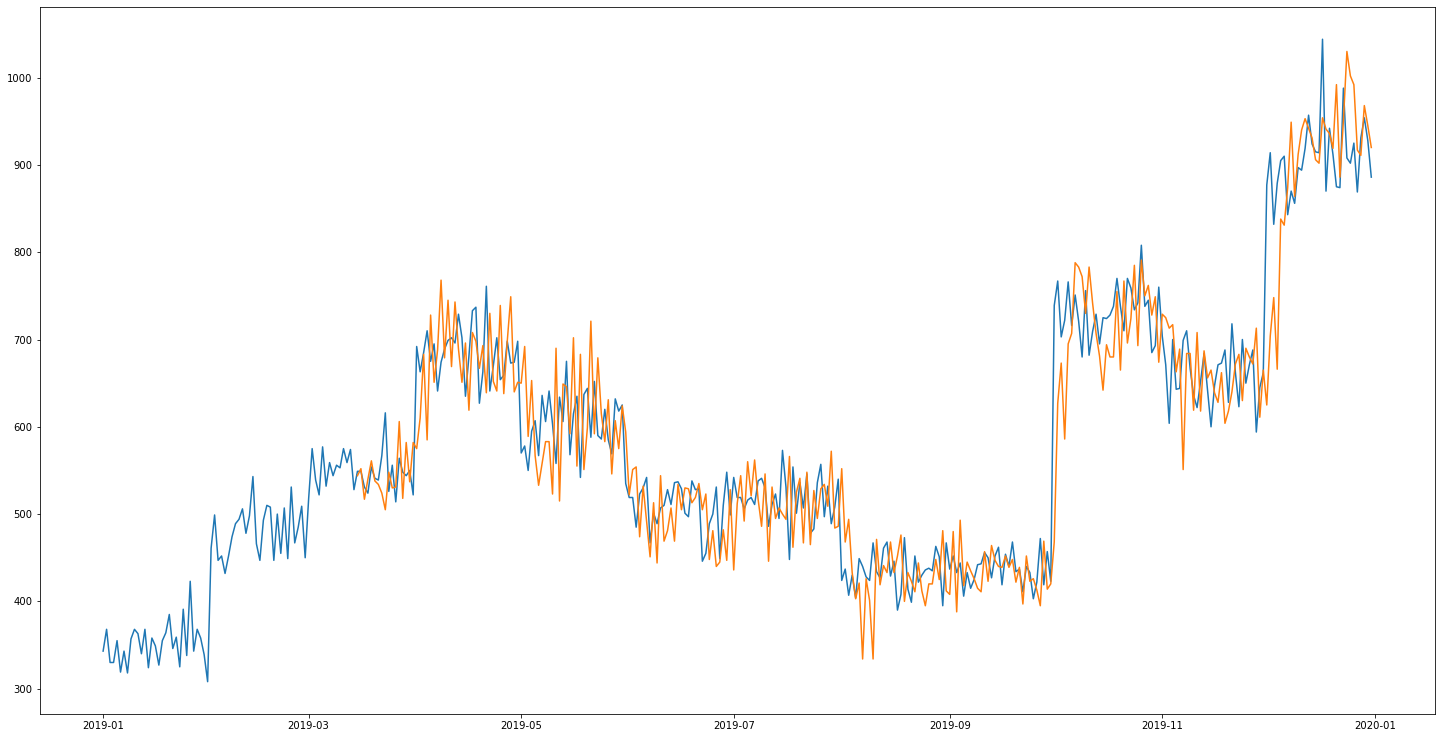

In [40]:
plt.figure(figsize=(25,13))
plt.plot(df_sales_pred['Order Date'],df_sales_pred['Quantity Ordered'])
plt.plot(df_sales_pred['Order Date'],df_sales_pred['pred_value'])
plt.show()